In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiLineString
from pathlib import Path

In [6]:
paths = []

for i in range (9) :
    paths.append(Path("data", f"Output{i+1}.geojson"))


In [7]:
def plot_map(path):

    gdf = gpd.GeoDataFrame.from_file(path)

    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(50, 50))

    fig.suptitle(path, fontsize=50)

    gdf.plot(ax=axs[0], aspect=1)
    gdf.boundary.plot(ax=axs[1], aspect=1)
    gdf.boundary.buffer(100).plot(ax=axs[2], aspect=1)

    axs[0].set_title("Original", fontsize=40)
    axs[1].set_title("Boundary", fontsize=40)
    axs[2].set_title("Buffered Boundary", fontsize=40)

    for ax in axs:
        ax.tick_params(axis='both', labelsize=30)

    plt.show()

    fig.savefig(Path("maps", f"{path.stem}.png"))

/var/folders/q_/vsjnlmyj0m5cvyg6zrmbf9lr0000gn/T/ipykernel_77833/70738086.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.boundary.buffer(100).plot(ax=axs[2], aspect=1)
/opt/miniconda3/envs/contour/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


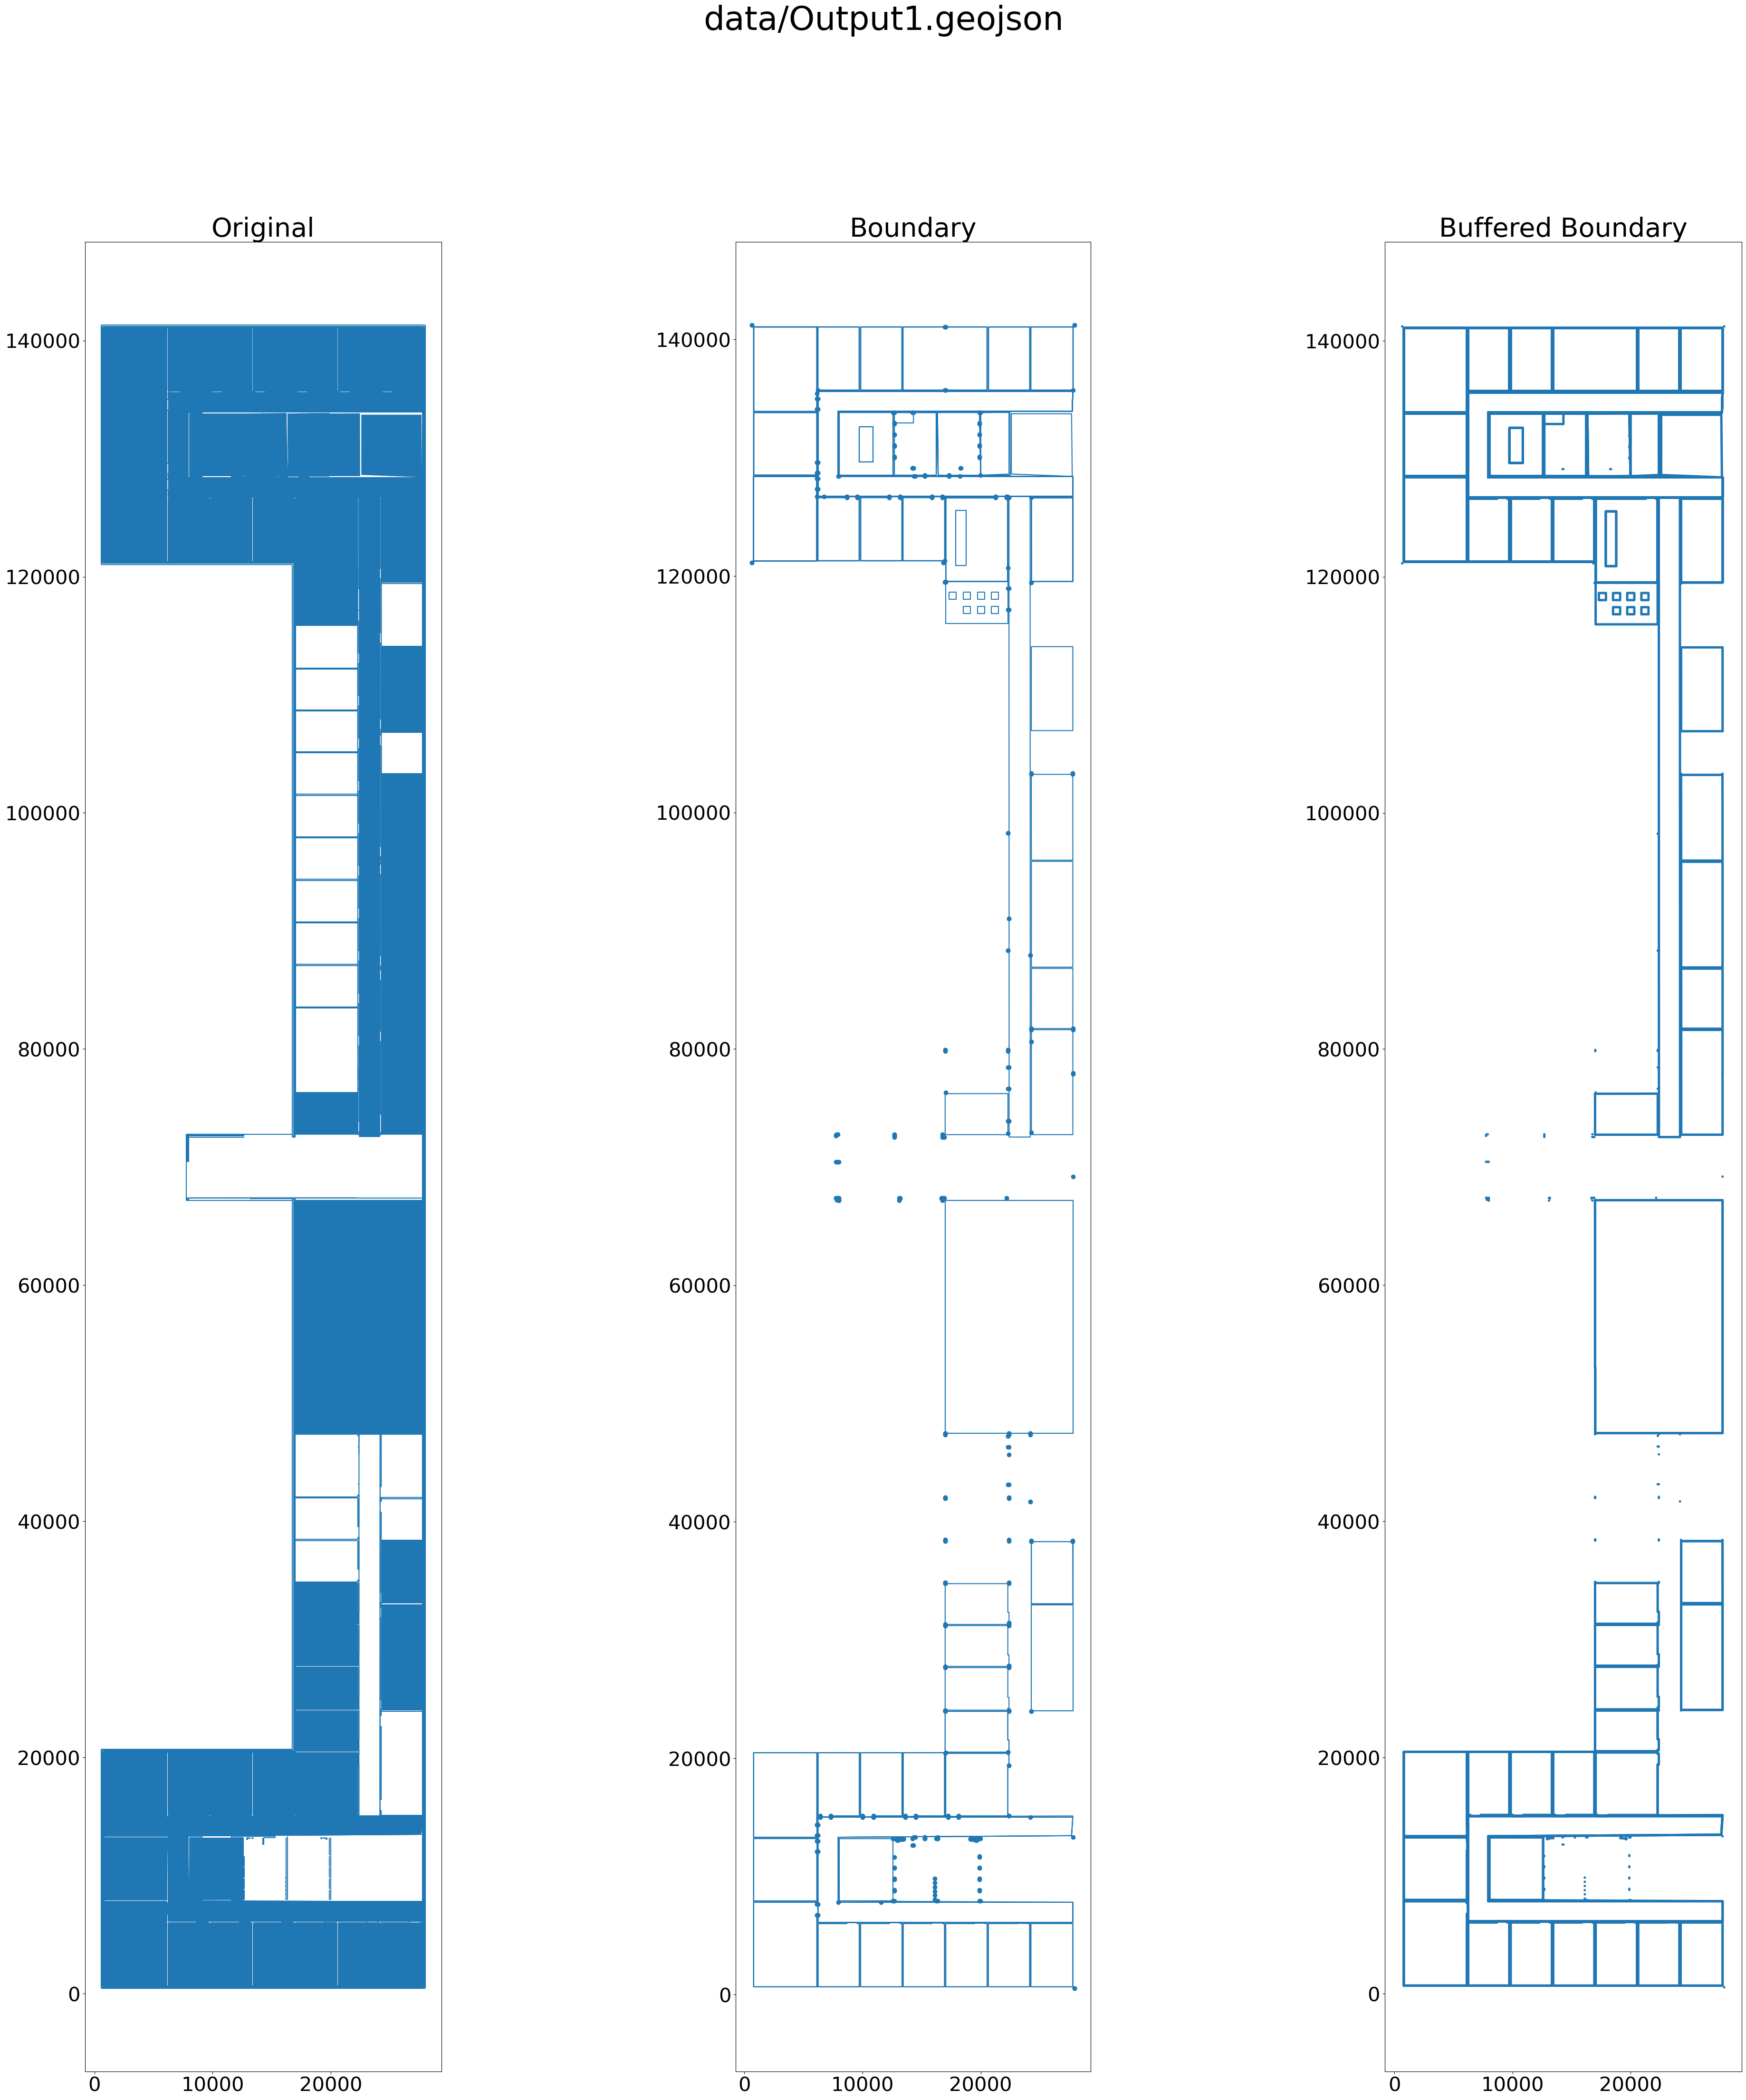

KeyboardInterrupt: 

In [8]:
for path in paths:
    plot_map(path)

In [10]:
#Nombre de features par fichier, nombre de features par type de géométrie, nombre de lignes de code par fichier

for path in paths:
    gdf = gpd.GeoDataFrame.from_file(path)
    print(f"   - {path.stem} : {len(gdf)} features")
    print(f"{gdf.geom_type.value_counts()}")
    print(f"{path.stem} : {len(open(path).readlines())} lignes de code\n")




   - Output1 : 252 features
Polygon            251
MultiLineString      1
Name: count, dtype: int64
Output1 : 23431 lignes de code

   - Output2 : 19 features
Polygon            18
MultiLineString     1
Name: count, dtype: int64
Output2 : 167572 lignes de code

   - Output3 : 1 features
MultiLineString    1
Name: count, dtype: int64
Output3 : 5377 lignes de code

   - Output4 : 7 features
Polygon            6
MultiLineString    1
Name: count, dtype: int64
Output4 : 9672 lignes de code

   - Output5 : 95 features
Polygon            94
MultiLineString     1
Name: count, dtype: int64
Output5 : 4203 lignes de code

   - Output6 : 686 features
Polygon            685
MultiLineString      1
Name: count, dtype: int64
Output6 : 45277 lignes de code

   - Output7 : 153 features
Polygon            152
MultiLineString      1
Name: count, dtype: int64
Output7 : 49592 lignes de code

   - Output8 : 1 features
MultiLineString    1
Name: count, dtype: int64
Output8 : 21 lignes de code

   - Output9 : 

In [5]:
def geojson_to_image(file_path, output_path, dpi=300):
    gdf = gpd.read_file(file_path)
    
    # Configurer la taille de la figure
    fig, ax = plt.subplots(1, 1, figsize=(1000, 1000))
    gdf.plot(ax=ax, color="black", edgecolor="white")
    
    # Enregistrer l'image
    plt.axis("off")  # Masquer les axes pour une image propre
    plt.savefig(output_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    print(f"Image générée : {output_path}")

for path in paths:
    output_image = path.with_suffix(".png")
    geojson_to_image(path, output_image)

NameError: name 'plt' is not defined

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def segment_image(image_path, output_path):
    # Charger l'image en niveaux de gris
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Binarisation (seuil)
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Détection des contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Créer une image pour visualiser les contours
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i, contour in enumerate(contours):
        color = tuple(np.random.randint(0, 255, 3).tolist())  # Couleur aléatoire
        cv2.drawContours(output, [contour], -1, color, 2)
    
    # Enregistrer l'image avec les contours
    cv2.imwrite(output_path, output)
    print(f"Image segmentée enregistrée : {output_path}")

# Appliquer la segmentation sur les images générées
for path in geojson_paths:
    image_path = path.with_suffix(".png")
    output_path = path.with_name(f"{path.stem}_segmented.png")
    segment_image(str(image_path), str(output_path))
